<a href="https://colab.research.google.com/github/ritamsarkar2000/ML/blob/master/estimators_with_boosted_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display
from IPython.display import clear_output

import tensorflow as tf

In [2]:
tf.random.set_seed(123)

In [3]:
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
train_y = dftrain.pop('survived')
eval_y = dfeval.pop('survived')

In [4]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [5]:
train_y.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

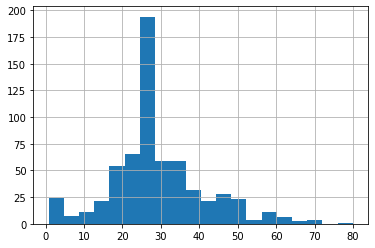

In [6]:
plt.hist(dftrain['age'], bins= 20)
plt.grid()
plt.show()

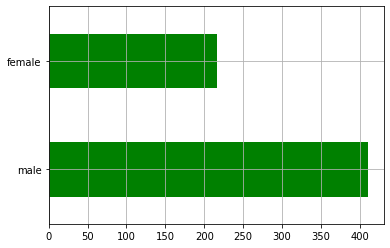

In [7]:
dftrain.sex.value_counts().plot(kind='barh', color='g')
plt.grid()
plt.show()

In [8]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_column = []

for feature_name in CATEGORICAL_COLUMNS:
  vocab = dftrain[feature_name].unique()
  feature_column.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocab))
for feature_name in NUMERIC_COLUMNS:
  feature_column.append(tf.feature_column.numeric_column(feature_name, dtype= tf.float32))  

In [9]:
def in_fn(train_data, train_label, training= True, repeat = None):
  ds= tf.data.Dataset.from_tensor_slices((dict(train_data), train_label))
  if training:
    ds= ds.shuffle(len(train_y))
  return ds.repeat(repeat).batch(len(train_y))

In [10]:
est_model= tf.estimator.BoostedTreesClassifier(feature_column, n_batches_per_layer=1)
est_model.train(input_fn = lambda: in_fn(dftrain, train_y, training= True), max_steps = 100)

eval_result = est_model.evaluate(input_fn = lambda: in_fn(dfeval, eval_y, training= False, repeat=1))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp8shk8f4m', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Varia

In [11]:
print(pd.Series(eval_result))

accuracy                  0.837121
accuracy_baseline         0.625000
auc                       0.867371
auc_precision_recall      0.857736
average_loss              0.408749
label/mean                0.375000
loss                      0.408749
precision                 0.825581
prediction/mean           0.372780
recall                    0.717172
global_step             100.000000
dtype: float64


In [12]:
pred_dicts = list(est_model.predict(input_fn = lambda: in_fn(dfeval, eval_y, training= False, repeat=1)))
probs = []
for pred in pred_dicts:
  probs.append(pd.Series([pred['probabilities'][1]]))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp8shk8f4m/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


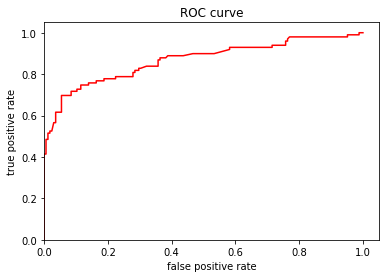

In [13]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(eval_y, probs)
plt.plot(fpr, tpr, color= 'r')
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()